# Training Code

In [1]:
import os, shutil, zipfile

# -------- INPUT LOCATION (change only this if needed) --------
src_path = "/kaggle/input/inputt"   # folder or zip
dst_dir = "/kaggle/working/cvat_data"

# Clean slate
if os.path.exists(dst_dir):
    shutil.rmtree(dst_dir)
os.makedirs(dst_dir, exist_ok=True)

# CASE 1: If it's a ZIP file
if os.path.isfile(src_path) and src_path.endswith(".zip"):
    print("Detected ZIP file → extracting...")
    with zipfile.ZipFile(src_path, 'r') as zip_ref:
        zip_ref.extractall(dst_dir)

# CASE 2: If it's already a folder
else:
    print("Detected FOLDER → copying contents...")
    for item in os.listdir(src_path):
        s = os.path.join(src_path, item)
        d = os.path.join(dst_dir, item)
        if os.path.isdir(s):
            shutil.copytree(s, d)
        else:
            shutil.copy2(s, d)

print("\nFinal contents in /kaggle/working/cvat_data:")
for root, dirs, files in os.walk(dst_dir):
    print(root, "→", dirs, files)

Detected FOLDER → copying contents...

Final contents in /kaggle/working/cvat_data:
/kaggle/working/cvat_data → ['yoloseg'] ['instances_default.json']
/kaggle/working/cvat_data/yoloseg → [] ['UFDjjwheat_RGB_0.0_0.0_20251210_143211581.webp', 'UFDjjwheat_RGB_0.0_0.0_20251209_150028535.webp', 'UFDjjwheat_RGB_0.0_0.0_20251208_130207142.webp']


In [2]:
import os, json, cv2
import numpy as np

cvat_root = "/kaggle/working/cvat_data"
json_files = [f for f in os.listdir(cvat_root) if f.endswith(".json")]

if len(json_files) == 0:
    raise FileNotFoundError(f"No JSON found inside {cvat_root}")

ann_file = os.path.join(cvat_root, json_files[0])
print(f"Using annotation file: {ann_file}")

yolo_root = "/kaggle/working/yolo_seg_data"
if os.path.exists(yolo_root):
    shutil.rmtree(yolo_root)

os.makedirs(os.path.join(yolo_root, "images"), exist_ok=True)
os.makedirs(os.path.join(yolo_root, "labels"), exist_ok=True)

with open(ann_file, "r") as f:
    coco = json.load(f)

cat_map = {}
for cat in coco["categories"]:
    name = cat["name"].lower()
    if "crop" in name:
        cat_map[cat["id"]] = 0
    else:
        cat_map[cat["id"]] = 1  # weed

images_dir = os.path.join(cvat_root, "yoloseg")

for img in coco["images"]:
    img_id, img_name = img["id"], img["file_name"]
    h, w = img["height"], img["width"]

    src = os.path.join(images_dir, img_name)
    dst = os.path.join(yolo_root, "images", img_name)
    if os.path.exists(src):
        cv2.imwrite(dst, cv2.imread(src))
    else:
        print(f"⚠️ Missing image: {src}")
        continue

    anns = [a for a in coco["annotations"] if a["image_id"] == img_id]
    label_lines = []
    for ann in anns:
        cls = cat_map[ann["category_id"]]
        poly = np.array(ann["segmentation"][0]).reshape(-1, 2)
        poly[:, 0] /= w
        poly[:, 1] /= h
        poly_str = " ".join([f"{x:.6f} {y:.6f}" for x, y in poly])
        label_lines.append(f"{cls} {poly_str}\n")

    lbl_name = os.path.splitext(img_name)[0] + ".txt"
    with open(os.path.join(yolo_root, "labels", lbl_name), "w") as f:
        f.writelines(label_lines)

print("✅ CVAT → YOLO conversion DONE!")

Using annotation file: /kaggle/working/cvat_data/instances_default.json
✅ CVAT → YOLO conversion DONE!


In [3]:
!pip install ultralytics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 21.0 MB/s eta 0:00:00


In [4]:
from ultralytics import YOLO
import yaml, os

data_yaml = {
    "path": "/kaggle/working/yolo_seg_data",
    "train": "images",
    "val": "images",
    "nc": 2,
    "names": ["Crop", "Weed"]
}

with open("/kaggle/working/seg_data.yaml", "w") as f:
    yaml.dump(data_yaml, f)

model = YOLO("yolov8n-seg.pt")

model.train(
    data="/kaggle/working/seg_data.yaml",
    epochs=120,
    imgsz=1280,
    batch=1,
    lr0=1e-3,
    iou=0.5,
    patience=0
)

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.
Ultralytics 8.4.13 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 14913MiB)
engine/trainer: agnostic_nms=False, amp=True, angle=1.0, augment=False, auto_augment=randaugment, batch=1, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/kaggle/working/seg_data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, end2end=None, epochs=120, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=1280, in

ultralytics.utils.metrics.SegmentMetrics object with attributes:

ap_class_index: array([0, 1])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x7a41a1fa5970>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)', 'Precision-Recall(M)', 'F1-Confidence(M)', 'Precision-Confidence(M)', 'Recall-Confidence(M)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.04104

In [5]:
# ==========================
# SECTION 4 — INFERENCE ON 27 IMAGES
# ==========================

import cv2, glob, os
import numpy as np
import matplotlib.pyplot as plt
from ultralytics import YOLO

# ---- Load your trained model ----
best_weight = glob.glob("/kaggle/working/runs/segment/**/best.pt", recursive=True)[-1]
print("Loading model:", best_weight)

seg_model = YOLO(best_weight)

# ---- Your 27 test images ----
test_dir = "/kaggle/input/toannot"
test_files = sorted(glob.glob(os.path.join(test_dir, "*.webp")))

print(f"Found {len(test_files)} test images.")


Loading model: /kaggle/working/runs/segment/train/weights/best.pt
Found 24 test images.


In [6]:
import cv2, glob, os
import numpy as np
import matplotlib.pyplot as plt
from ultralytics import YOLO

best_weight = glob.glob("/kaggle/working/runs/segment/**/best.pt", recursive=True)[-1]
seg_model = YOLO(best_weight)

def visualize_segmentation(img_path, conf=0.25):
    image = cv2.imread(img_path)
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    h, w, _ = image.shape

    results = seg_model.predict(image, conf=conf, imgsz=1280, verbose=False)[0]

    if results.masks is None:
        plt.figure(figsize=(12,8))
        plt.imshow(image_rgb)
        plt.axis("off")
        plt.show()
        return

    masks = results.masks.data.cpu().numpy()
    classes = results.boxes.cls.cpu().numpy()

    masks_resized = []
    for m in masks:
        m = cv2.resize(m.astype(np.uint8)*255, (w, h), interpolation=cv2.INTER_NEAREST)
        masks_resized.append(m > 127)
    masks_resized = np.array(masks_resized)

    overlay = np.zeros((h, w, 4), dtype=np.float32)

    for i, mask in enumerate(masks_resized):
        if mask.sum() < 5:
            continue
        color = [np.random.rand(), np.random.rand(), np.random.rand(), 0.7] if classes[i] == 1 else [1, 1, 0, 0.3]
        overlay[mask] = color

    plt.figure(figsize=(12,8))
    plt.imshow(image_rgb)
    plt.imshow(overlay, alpha=0.7)
    plt.axis("off")
    plt.show()

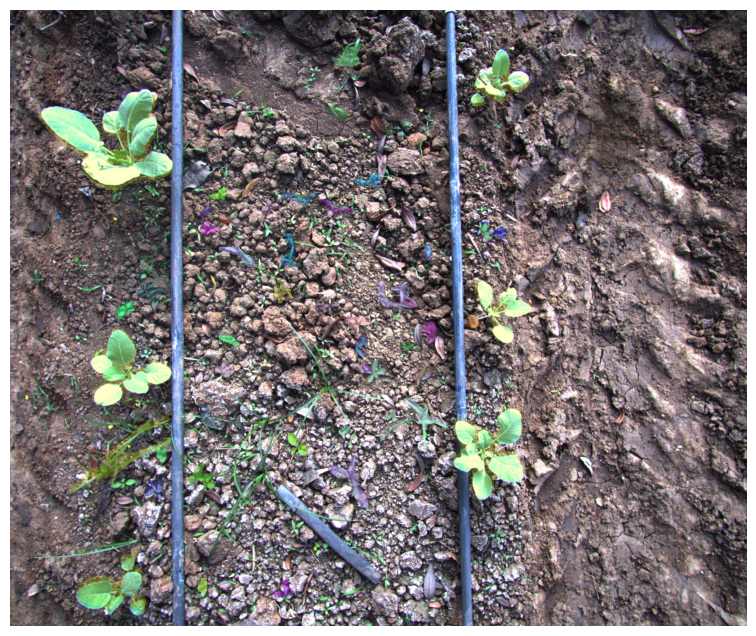

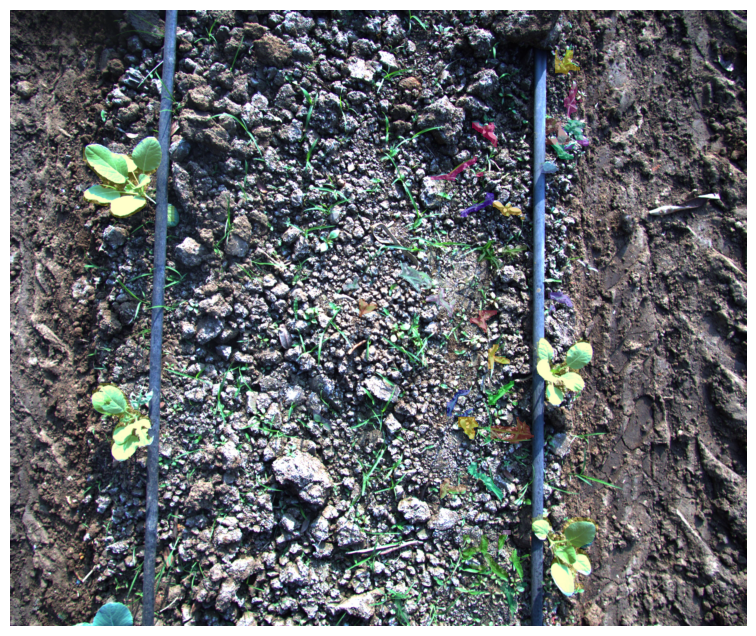

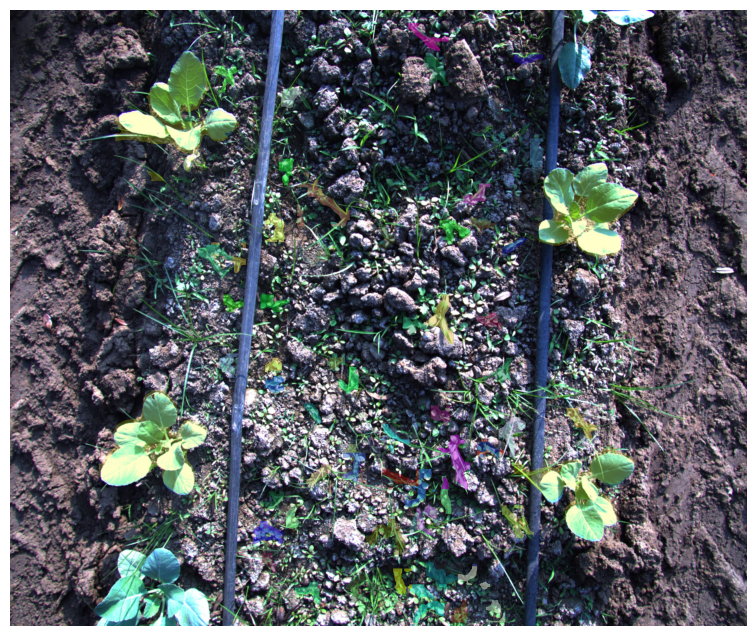

In [7]:
test_dir = "/kaggle/input/toannot"
test_files = sorted(glob.glob(os.path.join(test_dir, "*.webp")))

for i in range(3):
    visualize_segmentation(test_files[i], conf=0.25)

In [8]:
# import glob
# from ultralytics import YOLO

# old_model_path = "/kaggle/working/runs/segment/train/weights/best.pt"
# model = YOLO(old_model_path)

# print("Using stable model:", old_model_path)


In [9]:
# import os, cv2
# import numpy as np
# from ultralytics import YOLO

# output_dir = "/kaggle/working/final_predictions"
# os.makedirs(output_dir, exist_ok=True)

# def run_segmentation_and_save(img_path, model, conf=0.01):
#     name = os.path.splitext(os.path.basename(img_path))[0]
#     img = cv2.imread(img_path)
#     h, w = img.shape[:2]

#     res = model.predict(img, conf=conf, imgsz=1280)[0]

#     if res.masks is None or len(res.masks.data) == 0:
#         print(f"⚠️ No masks for {name}, skipping.")
#         return

#     mask_stack = np.zeros((h, w), dtype=np.int32)

#     instance_id = 1
#     for i, mask in enumerate(res.masks.data.cpu().numpy()):
#         cls = int(res.boxes.cls[i])  # 0 = Crop, 1 = Weed

#         # Resize to full image
#         mask = cv2.resize(mask, (w, h), interpolation=cv2.INTER_NEAREST)
#         mask = (mask > 0.5).astype(np.uint8)

#         if mask.sum() < 50:
#             continue  # skip tiny junk

#         # Assign unique instance ID per weed/crop
#         mask_stack[mask == 1] = instance_id
#         instance_id += 1

#     # Save instance mask image
#     save_path = os.path.join(output_dir, name + "_instances.png")
#     cv2.imwrite(save_path, (mask_stack % 255).astype(np.uint8))

#     print(f"Saved instance mask → {save_path}")


In [10]:
# import glob

# test_images = sorted(glob.glob('/kaggle/input/toannot/*.webp'))

# for img in test_images:
#     run_segmentation_and_save(img, model, conf=0.01)

# print("All images processed!")


# Inference Code

In [11]:
# # =================== USER CONFIG (ONLY LINE TO CHANGE) ===================
# INPUT_IMAGE_DIR = "/kaggle/input/toannot"   # <-- EXAMINER ONLY CHANGES THIS
# # ========================================================================


In [12]:
# import os, glob, cv2
# import numpy as np
# from ultralytics import YOLO

# # ---------- Load trained model (fixed path) ----------
# MODEL_PATH = "/kaggle/working/runs/segment/train/weights/best.pt"
# model = YOLO(MODEL_PATH)

# # ---------- Output directory (fixed structure) ----------
# OUTPUT_DIR = "/kaggle/working/instance_outputs"
# os.makedirs(OUTPUT_DIR, exist_ok=True)


In [13]:
# def save_instance_mask(image_path, model, conf=0.01, imgsz=1280):
#     name = os.path.splitext(os.path.basename(image_path))[0]
#     img = cv2.imread(image_path)

#     if img is None:
#         print(f"❌ Could not read: {image_path}")
#         return

#     h, w = img.shape[:2]

#     # Run segmentation
#     res = model.predict(img, conf=conf, imgsz=imgsz)[0]

#     # If no masks, save empty mask
#     if res.masks is None or len(res.masks.data) == 0:
#         empty = np.zeros((h, w), dtype=np.uint8)
#         cv2.imwrite(os.path.join(OUTPUT_DIR, name + "_instances.png"), empty)
#         print(f"⚠️ No detections → saved empty mask: {name}")
#         return

#     instance_map = np.zeros((h, w), dtype=np.int32)
#     instance_id = 1

#     for i, mask in enumerate(res.masks.data.cpu().numpy()):
#         mask = cv2.resize(mask, (w, h), interpolation=cv2.INTER_NEAREST)
#         mask = (mask > 0.5).astype(np.uint8)

#         if mask.sum() < 50:   # remove tiny noise
#             continue

#         instance_map[mask == 1] = instance_id
#         instance_id += 1

#     out_path = os.path.join(OUTPUT_DIR, name + "_instances.png")
#     cv2.imwrite(out_path, (instance_map % 255).astype(np.uint8))
#     print(f"Saved: {out_path}  |  Instances: {instance_id-1}")


In [14]:
# if __name__ == "__main__":
#     image_files = sorted(glob.glob(os.path.join(INPUT_IMAGE_DIR, "*.webp")) +
#                          glob.glob(os.path.join(INPUT_IMAGE_DIR, "*.jpg")) +
#                          glob.glob(os.path.join(INPUT_IMAGE_DIR, "*.png")))

#     print(f"Found {len(image_files)} images in: {INPUT_IMAGE_DIR}")

#     for img_path in image_files:
#         save_instance_mask(img_path, model)

#     print("\n✅ INFERENCE COMPLETE!")
#     print(f"Outputs saved to: {OUTPUT_DIR}")


In [15]:
# import shutil

# # Path to your trained model in Kaggle
# src = "/kaggle/working/runs/segment/train/weights/best.pt"
# dst = "/kaggle/working/weed_crop_seg.pt"

# shutil.copy(src, dst)
# print("Saved as single file:", dst)


In [16]:
# import shutil
# # Zip the weights folder so it downloads as a single .zip file
# shutil.make_archive('my_model_weights', 'zip', '/kaggle/working/runs/segment/train/weights/')